In [1]:
import scipy.io as mt # to load .mat MATLAB file
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

Loading data from a MATLAB binary file with extension `.mat`
data into a dictionary, where X and y elements are numpy arrays.

In [2]:
data = mt.loadmat('ex3data1.mat')
#data is a dictionary and each element is a numpy array
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
print('X shape is: ', data['X'].shape) # shape of X (5000,400)
print('y shape is: ', data['y'].shape) # shape of y (5000,1)


X shape is:  (5000, 400)
y shape is:  (5000, 1)


shape of XX: (5000, 401)
shape of y: (5000,)


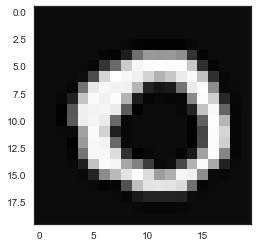

In [4]:
# add one column for intercept
XX = np.c_[np.ones((data['X'].shape[0],1)), data['X']] #(5000,401)
y = data['y'][:,0]                                    #(5000,1)
print('shape of XX: {}'.format(XX.shape)) #(5000,401)
print('shape of y: {}'.format(y.shape)) #(5000,)

# to test, reshape a 400 vector to a 20x20 pixels picture
x1 = XX[5,1:].reshape([20,20])
pl.imshow(x1,cmap='gray')
pl.show()

[ 3  2 10  5  3  9  8  7  7  3  2  3 10  2  4  7  7 10  2  5  8  8 10  1  5]


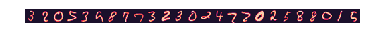

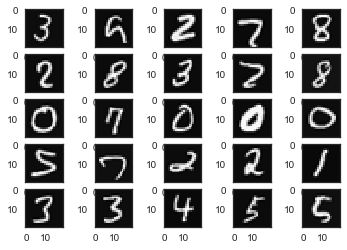

In [5]:
# randomly choose 25 picture and plot them
indx = np.random.choice(XX.shape[0],25)
pl.imshow(XX[indx,1:].reshape(-1,20).T)
pl.axis('off')

# Different way for plotting
dfig = XX[indx,1:].reshape([25,20,20])
print(y[indx])
fig, ax = pl.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[j,i].imshow(dfig[i*5+j,:,:].T, cmap='gray')
pl.show()

#### Sigmoid function
$$ g(z) = \frac{1}{1+e^{-z}} $$

In [6]:
def sigmoid(h):
    return (1./ (1 + np.exp(-h)))


#### Regularized Cost Function
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)} \ln(h_\theta(x^{(i)})) - (1-y^{(i)})\ln(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum_{i=1}^n \theta_j^2$$

#### Vectorized Cost Function


In [7]:
def costF(theta,beta,XX,y):
    """Vectorized regularized logistic cost function
    XX: features,
    y: target, labels
    theta: hypothesis coefficient
    beta: regularization parameter"""
    
    m = y.shape[0]
    h = sigmoid(XX.dot(theta))
    
    J = (-1./m) * ( y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h)) - \
                      0.5*beta*theta[1:].T.dot(theta[1:]) )
    if np.isnan(J):
        return(np.inf)
    
    return J

In [8]:
def grad_costF(theta,beta,XX,y):
    """The gradient of regularized logistic cost function."""
    m = y.shape[0]
    h = sigmoid(XX.dot(theta))
    aux = ( (1./m) * ( XX.T.dot(h - y) + beta*np.r_[0,theta[1:]] ) )
    #print('aux shape', aux.shape)
    return aux
    

In [9]:
from scipy.optimize import minimize
def oneVsall(XX, y, Nlabels, beta):
    theta_int = np.zeros((XX.shape[1])) # (401,1)
    all_theta = np.zeros((Nlabels,XX.shape[1])) # (10,401)
    
    for i in range(1,Nlabels+1):
        target_i = (y==i)*1        # training for y = i
        res = minimize(costF, theta_int, args=(beta,XX, target_i), method=None,
                        jac=grad_costF, options={'maxiter':50})
        all_theta[i-1] = res.x
    return(all_theta)


In [12]:
def predictOneVsAll(all_theta, XX):
    probs = sigmoid(XX.dot(all_theta.T))
        
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis=1)+1)

In [13]:
pred = predictOneVsAll(theta, XX)
print('Training set accuracy: {} %'.format(np.mean(pred == y)*100))

Training set accuracy: 93.24 %


#### Logistic Regression with scikit-learn

In [14]:
import sklearn.linear_model as skl

In [15]:
clf = skl.LogisticRegression(C=10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude the intercept column 
clf.fit(XX[:,1:], y) #fitting the features with targets

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
pred2 = clf.predict(XX[:,1:])
print('Training set accuracy: {} %'.format(np.mean(pred2==y)*100))
pred2

Training set accuracy: 96.5 %


array([10, 10, 10, ...,  9,  9,  7], dtype=uint8)

#### Neural Network FeedForward Propagation

In [17]:
weights = mt.loadmat('ex3weights.mat')

In [18]:
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [19]:
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print(theta1.shape)
print(theta2.shape)

(25, 401)
(10, 26)


In [20]:
def forwardPredict(XX,theta1,theta2):
    z2 = XX.dot(theta1.T)
    a20 = sigmoid(z2)
    a2 = np.c_[np.ones((XX.shape[0],1)),a20]
    
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)
    
    return (np.argmax(a3,axis=1)+1)

In [21]:
pred = forwardPredict(XX,theta1, theta2)
np.mean(pred==y)

0.97519999999999996